# Принятие решений в бизнесе интернет-магазина. 

**Описание проекта.**

Командой аналитиков подготовлен список гипотез для увеличения выручки интернет-магазина. В проекте проведена
приоритизация гипотез, анализ результатов A/B-теста.

**Описание данных.**

В распоряжении три датасета. Файл **hypothesis.csv** со списком гипотез, **orders.csv** — информация о заказах, а **visitors.csv** — информация о визитах пользователей.

Список гипотез - **hypothesis.csv**

Название столбца      | Расшифровка
:-------------:       |:-------------:
**Hypothesis**        | краткое описание гипотезы
**Reach**             | охват пользователей по 10-балльной шкале
**Impact**            |	влияние на пользователей по 10-балльной шкале
**Confidence**        |	уверенность в гипотезе по 10-балльной шкале
**Efforts**           |	затраты ресурсов на проверку гипотезы по 10-балльной шкале


Информация о заказах - **orders.csv**

Название столбца      | Расшифровка
:-------------:       |:-------------:
**transactionId**     | идентификатор заказа
**visitorId**         | идентификатор пользователя, совершившего заказ
**date**              |	дата, когда был совершён заказ
**revenue**           | выручка заказа
**group**             |	группа A/B-теста, в которую попал заказ

Информация о визитах пользователей - **visitors.csv**

Название столбца | Расшифровка
:-------------:  |:-------------:
**date**         | дата
**group**        | группа A/B-теста
**visitors**     | количество пользователей в указанную дату в указанной группе A/B-теста

**Цель исследования:**

- выполнить приоритизацию гипотез;
- выполнить анализ результатов проведенного А/В теста;
- принять решение об остановке или продолжении теста.

**Ход исследования:**

1) Открытие файлов, изучение общей информации о полученных датафреймах, предобработка данных.

2) Приоритизация гипотез с помощью фреймворков ICE и RICE;

3) Анализ результатов А/В теста:

    - анализ кумулятивных данных по группам;

    - построение точечных графиков количества и стоимости заказов по пользователям;

    - определение границ для аномальных данных с помощью подсчета перцентилей;

    - подсчет статистической значимости различий между группами по «сырым» и «очищенным» данным.
    
4) Вывод по резульатам исследованных данных.

### Загрузка данных, подготовка к анализу

#### Загрузка данных.

In [1]:
# импорт нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import scipy.stats as stats

In [2]:
# чтение файлов с данными
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # список гипотез
    pd.read_csv('/datasets/orders.csv'),  # заказы
    pd.read_csv('/datasets/visitors.csv')  # визиты
)

In [3]:
# снятие ограничений на количество отображаемых столбцов и количество символов в записи
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#### Изучение общей информации.

Выведем первые строки таблиц и общую информацию о каждом датафрейме.

In [4]:
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В приведенных таблицах отсутсвуют пропуски. Поэтому на этапе предобработки данных планируется следующее:

- проверить датафреймы на наличие дубликатов;
- привести столбцы с датой к типу datetime;
- привести названия столбцов к единому стилю (строчные буквы, удаление пробелов).

#### Предобработка данных.

In [7]:
# проверка датафреймов на наличие явных дубликатов
[data.duplicated().sum() for data in [hypothesis, orders, visitors]]

[0, 0, 0]

In [8]:
# приведение названия столбцов таблиц к нижнему регистру 
orders.columns = [x.lower().replace('id', '_id') for x in orders.columns]
hypothesis.columns = [x.lower() for x in hypothesis.columns]

display(orders.columns)
display(hypothesis.columns)

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [9]:
# приведение столбцов с датой и временем к типу datetime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

### Приоритизация гипотез

Датафрейм **hypothesis** содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Задача на данном этапе:
- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.

In [10]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False).round(2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Методом ICE, использующий параметры Влияние, Уверенность, Усилия выявлены приоритетные гипотезы 8,0,7,6,2.

Воспользуемся методом приоритизации RICE с добавлением параметра Rich (Охват) и посмотрим на распределение приоритетов.

In [11]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False).round(2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Аналогичные гиопотезы вошли в топ-5 лидирущих, но приоритет изменился. Это связано с тем, что у 7 гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" высокий уровень охвата, так как затронет всех пользователей, 

Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" имеет высокий приоритет методом ICE за счет высоких значений параметров влияния и низкого уровня стоимости тестирования гиоптезы (пользователи, знающие об этой акции точно смогут ей воспользоваться), но с добавлением параметра охвата в методе RICE теряет приоритет, так как воспользоваться акцией сможет небольшой процент пользователей.

Отсюда можно сделать вывод, что стоит обратить внимание в первую очерердь на тестирование следующих гиоптез:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	

### Анализ A/B-теста

На данном этапе выполним следующее: 

- проведем анализ кумулятивных данных по группам (выручки, среднего чека, относительного изменения кумулятивного среднего чека, среднего количества заказов на посетителя, относительного изменения кумулятивного среднего количества заказов);

- построим точечные графики количества и стоимости заказов по пользователям;

- определим границу для аномальных данных с помощью подсчета перцентилей;

- посчитаем статистическую значимость различий между группами по «сырым» и «очищенным» данным.

Проверим, нет ли пользователей, попавших одновременно в обе группы.

In [12]:
user_both = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'revenue': 'sum'}).reset_index()
cnt = user_both.query('group > 1')['visitor_id'].count()
rev = user_both.query('group > 1')['revenue'].sum()
print(f'Пользователей, попавших в обе группы: {cnt}')
print(f'Выручка от этих пользователей составляет: {rev}')

Пользователей, попавших в обе группы: 58
Выручка от этих пользователей составляет: 1558935


Присутсвует 58 пользователей с общей выручкой более 1,5 млн., которые попали в обе группы во время проведения теста. Так как неизвестно, какой из тестируемых вариантов повлиял на действия этих пользователей, удалим их id из таблицы orders.

In [13]:
list_user_both = list(user_both.query('group > 1')['visitor_id'])
orders = orders.query('visitor_id not in @list_user_both')

#### Анализ графиков кумулятивных  данных.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData, содержащий столбцы:

* `date` — дата;
* `group` — группа A/B-теста (A или B);
* `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
* `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
* `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
* `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
                    ].agg(
                            {'date' : 'max', 
                             'group' : 'max', 
                             'transaction_id' : 'nunique', 
                             'visitor_id' : 'nunique',
                             'revenue' : 'sum'}
                          ), axis=1).sort_values(by=['date','group'])

ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [15]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
                      ].agg(
                            {'date' : 'max',
                             'group' : 'max', 
                             'visitors' : 'sum'}
                            ), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# переименовываем названия столбцов
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


##### график кумулятивной выручки по группам

Построим графики кумулятивной выручки по дням и группам A/B-тестирования

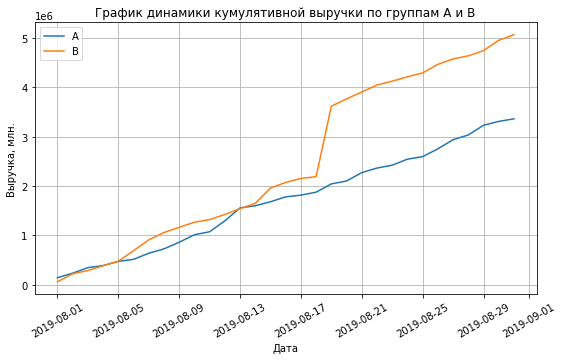

In [16]:
cumulativeRevenueA = cumulativeData.query('group == "A"')
cumulativeRevenueA = cumulativeRevenueA[['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData.query('group == "B"')
cumulativeRevenueB = cumulativeRevenueB[['date','revenue', 'orders']]

plt.figure(figsize=(9,5))
plt.grid(b=True)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График динамики кумулятивной выручки по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.xticks(rotation=30)
plt.legend()

plt.show()

По графику видно, что выручка группы А равномерно увеличивается в течение всего теста. При этом выручка группы А ниже выручки группы В.

Однако график выручки группы В резко возрастает около 18 августа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке группы В.

##### график кумулятивного среднего чека по группам

Построим графики среднего чека по группам, разделив кумулятивную выручку на кумулятивное число заказов

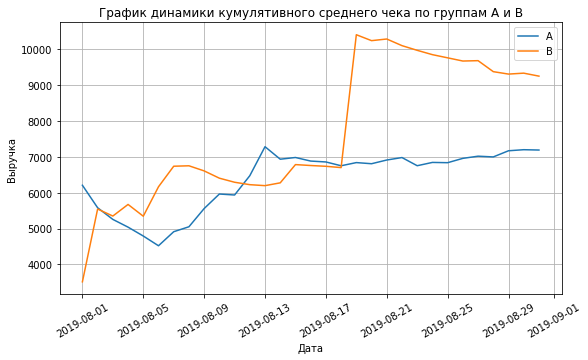

In [17]:
plt.figure(figsize=(9,5))
plt.grid(b=True)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=30)
plt.legend()

plt.show()

Средний чек группы А становится равномерным и устанавливается с середины теста. 
Видно резкий всплеск на графике среднего чека группы В около 18 августа, значит, можно утверждать о наличии покупки высокой стоимости. После этого график группы В равномерно убывает, при этом средний чек выше, чем у группы А.

##### график относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека.

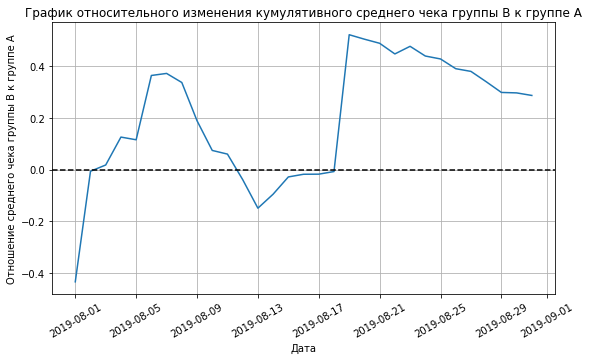

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(9,5))
plt.grid(b=True)
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
                                            (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Скачок около 18 августа продолжает сохраняться. Точно спрятались крупные заказы и выбросы.

##### график кумулятивного среднего количества заказов на посетителя по группам

Аналогично проанализируем график кумулятивного среднего количества заказов

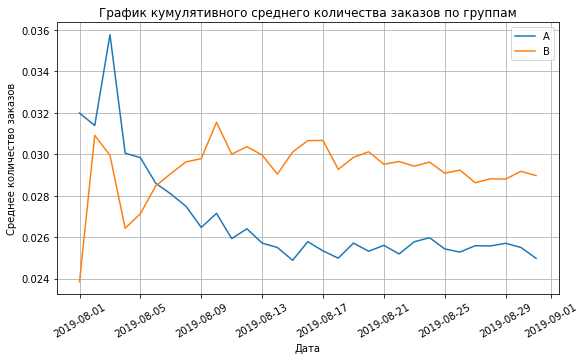

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(9,5))
plt.grid(b=True)

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=30)
plt.show()


В начале теста средние значения по количеству заказов обеих групп сильно колебались, к середине теста выровнялись. При этом среднее значение количества заказов группы В выше группы А.

 ##### график относительного различия кумулятивного среднего количества заказов

Построим график относительного различия кумулятивного среднего количества заказов

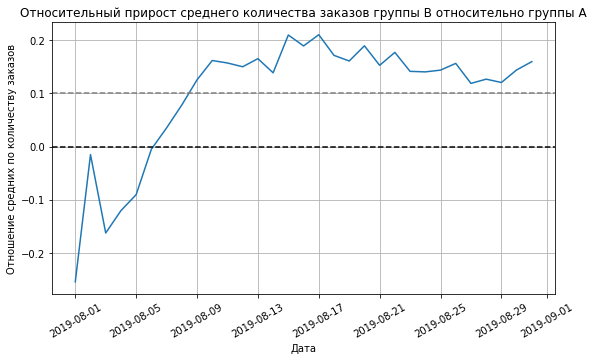

In [20]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

plt.figure(figsize=(9,5))
plt.grid(b=True)

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.title('Относительный прирост среднего количества заказов группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Отношение средних по количеству заказов')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xticks(rotation=30)
plt.show()


В начале теста группа В проигрывала по количеству заказов группе А. После чего отношение стабилизировалось.

#### Анализ графиков количетсва заказов и выручки по пользователям.

##### точечный график количества заказов по пользователям

In [21]:
cnt_order = orders.groupby('visitor_id')['transaction_id'].nunique().reset_index()
cnt_order.columns = ['visitor_id', 'orders']
cnt_order.sort_values('orders', ascending=False).head()

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


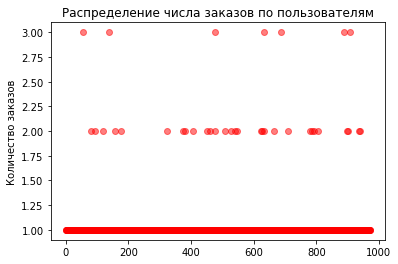

In [22]:
x_values = pd.Series(range(0, len(cnt_order)))

plt.scatter(x_values, cnt_order['orders'], c='red', alpha=0.5) 
plt.title('Распределение числа заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

Пользователей, сделавших более 1 заказа совсем мало. Но 2 и 3 заказа - не такое уж и большое количество. Посчитаем выборочные перцентили количества заказов на пользователя.

In [23]:
np.percentile(cnt_order['orders'], [95, 99])

array([1., 2.])

Не более 1% пользователей сделали больше 2 заказов. Примем за верхнюю границу 2 заказа на одного пользователя.

##### точечный график стоимостей заказов

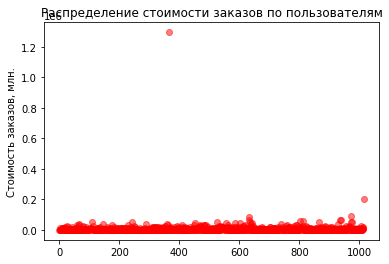

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], c='red', alpha=0.5) 
plt.title('Распределение стоимости заказов по пользователям')
plt.ylabel('Стоимость заказов, млн.')
plt.show()

Один заказ, стоимостью более 1.2 млн. давал скачки на графиках выручки и среднего чека. Посмторим график ближе без выбросов.

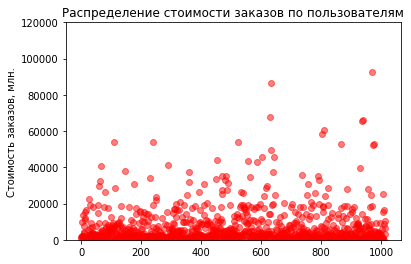

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.ylim(0, 120000)
plt.scatter(x_values, orders['revenue'], c='red', alpha=0.5) 
plt.title('Распределение стоимости заказов по пользователям')
plt.ylabel('Стоимость заказов, млн.')
plt.show()

Основная часть заказов не превышает 20 тысяч. Посчитаем выборочные перцентили стоимости заказов на пользователя.

In [26]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 1% пользователей сделали заказ больше, чем на 53904 у.е.. Примем за верхнюю границу стоимость заказа 53904 на одного пользователя.

#### Статистический анализ

* Ранее мы оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы;

* Увидели выбросы и нашли границу для их определения.

##### Анализ по «сырым» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

Объявим датафрейм data, содержащий столбцы:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitor_id', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [28]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']



Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [29]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']))
                                   , name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']))
                                   , name='orders')],axis=0)

**Посчитаем статистическую значимость различия *среднего количества заказов*, применив тест Манна-Уитни**

Применим непараметрический тест Уилкоксона-Манна-Уитни, воспользуясь методом st.mannwhitneyu() и выберем уровень значимости alpha = 0.05

Сформулируем нулевую и альтернативную гиоптезы: 

\begin{equation*}
 \begin{cases}
   H_0 :\text{не наблюдается статистически значимой разницы между группами}\\
   H_1 :\text{наблюдается статистически значимая разница между группами}
 \end{cases}
\end{equation*}

In [30]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print("P-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.2%}".format(sampleB.mean() / sampleA.mean()-1))

P-value: 0.011
Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами
Относительный прирост В к А: 15.98%


По неочищенным данным наблюдается статистически значимая разница в среднем количестве заказов между группами.

P-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий между группами нет, отвергаем.

Относительный выигрыш группы B равен 15.98%.

**Посчитаем статистическую значимость различия в среднем чеке заказа, применив тест Манна-Уитни**

Применим непараметрический тест Уилкоксона-Манна-Уитни, воспользуясь методом st.mannwhitneyu() и выберем уровень значимости alpha = 0.05

Сформулируем нулевую и альтернативную гиоптезы: 

\begin{equation*}
 \begin{cases}
   H_0 :\text{не наблюдается статистически значимой разницы между группами}\\
   H_1 :\text{наблюдается статистически значимая разница между группами}
 \end{cases}
\end{equation*}

In [31]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print("P-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.2%}".format(orders[orders['group']=='B']['revenue'].mean() 
                                                    / orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.829
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 28.66%


По неочищенным данным не наблюдается статистически значимой разницы в среднем чеке заказов между группами нет.

P-value = 0.829 меньше 0.05. Значит, нет оснований отвергать нулевую гипотезу о том, что статистически значимых различий между группами нет.

Относительный выигрыш группы B равен 28.66%. Различия между средними чеками есть: средний чек группы В больше.

##### Анализ по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 53904.0. 

Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 53904.0 — users_with_expensive_orders. Объединим их в таблице abnormal_users.

Узнаем, сколько всего аномальных пользователей.

In [32]:
many_orders = np.percentile(cnt_order['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)

users_with_many_orders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > many_orders]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_users.head(5))
print(f'Таких пользователей: {len(abnormal_users)}')

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitor_id, dtype: int64

Таких пользователей: 16


Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [33]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

**Посчитаем статистическую значимость различия *среднего количества заказов*, применив тест Манна-Уитни**

Применим непараметрический тест Уилкоксона-Манна-Уитни, воспользуясь методом st.mannwhitneyu() и выберем уровень значимости alpha = 0.05

Сформулируем нулевую и альтернативную гиоптезы: 

\begin{equation*}
 \begin{cases}
   H_0 :\text{не наблюдается статистически значимой разницы между группами}\\
   H_1 :\text{наблюдается статистически значимая разница между группами}
 \end{cases}
\end{equation*}

In [34]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("P-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.2%}".format(sampleBFiltered.mean() / sampleAFiltered.mean()-1))

P-value: 0.007
Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами
Относительный прирост В к А: 18.92%


По очищенным данным разница в среднем количестве заказов между группами наблюдается статистически значимая разница, а относительный прирост группы В отнистельно группы А равен 18.92%

**Посчитаем статистическую значимость различия в среднем чеке заказа, применив тест Манна-Уитни**

Применим непараметрический тест Уилкоксона-Манна-Уитни, воспользуясь методом st.mannwhitneyu() и выберем уровень значимости alpha = 0.05

Сформулируем нулевую и альтернативную гиоптезы: 

\begin{equation*}
 \begin{cases}
   H_0 :\text{не наблюдается статистически значимой разницы между группами}\\
   H_1 :\text{наблюдается статистически значимая разница между группами}
 \end{cases}
\end{equation*}

In [35]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[
                                    np.logical_and(orders['group'] == 'A',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'], 
                             orders[
                                    np.logical_and(orders['group'] == 'B',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'])[1]
print("P-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: наблюдается статистически значимая разница между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост В к А: {0:.2%}".format(orders[
                                    np.logical_and(orders['group'] == 'B',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean() 
                                                    / orders[
                                    np.logical_and(orders['group'] == 'A',
                                                   np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean()-1))

P-value: 0.788
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -3.23%


По очищенным данным нет оснований считать группы разными: различия в среднем чеке заказов не являются статистически значимыми.

P-value = 0.788 значительно больше 0.05. Значит, нет оснований отвергать нулевую гипотезу о том, что статистически значимых различий между группами нет.

По разнице средних чеков групп различий практически нет.

### Вывод

В проекте проведена приоритизация гипотез и анализ результатов A/B-теста интерент-магазина.
Данные, предоставленные для анализа содержат следующую информацию:
 - список гипотез,
 - информацию о заказах с сайта,
 - информация о визитах пользователей и группе.
   
**На этапе предобработки данных выполнено:**

- открыты файлы, изучена общая информацию о полученных датафреймах; 
- выполнена предобработка данных: заменены названия столбцов; выполнена проверка на дубликаты; выполнено преобразования типов данных, где это необходимо для дальнейшего анализа.

**На этапе анализа А/В теста:**

1) Анализ графиков:

    - выявлены и удалены пользователи, попавшие в обе группы теста;
    - выручка группы А равномерно увеличивается в течение всего теста аналогично графику группы В. При этом выручка группы А ниже выручки группы В. Однако на графике выручки группы В есть резкий скачок, сигнализирующий о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке группы В;
    - средний чек группы А становится равномерным и устанавливается с середины теста. Виден резкий всплеск на графике среднего чека группы В, свидетельствующий о наличии покупки высокой стоимости. После этого график группы В равномерно убывает, при этом средний чек выше, чем у группы А;
    - график кумулятивного среднего количества заказов группы В показывает стабильно лучшие значения, чем график группы А;
    
2) Статистический анализ:

    - присутствует статистически значимое различие по среднему количеству заказов между группами как по «сырым» данным, так и по данным после удаления аномалий. Относительный выигрыш группы B увеличился с 15.98 до 18.92 после удаления выбросов;
    - нет статистически значимого различия по среднему чеку между группами как по «сырым» данным, так и по «очищенным». При этом относительный выигрыш группы В до очистки данных равен 28.66%, а после очитски данных -3.23%. Это говорит о том, что среди пользователей группы В были совершены покупки на крупную сумму;
    
3) Тест можно остановить со следующими результатами: победа группы В по среднему количеству заказов.

Различия в среднем количестве заказов статистически значимы. При этом различий в среднем чеке заказов между группами по результатам теста не наблюдается.

Так как среднее количество заказов группы В выше, чем среднее количество заказов группы А, можно говорить о том, что изменения ведут к переходу пользователей в покупатели и впоследствии к увеличеню выручки.

График относительного прироста среднего количества заказов группы B относительно группы A говорит о том, что есть тенденция к улучшению.